<h1>Chapter 5 | Data Exercise #1 | Financial Assets | Generalizing from Data</h1>
<h2>Introduction:</h2>
<p>In this notebook, you will find my notes and code for Chapter 5's <b>exercise 1</b> of the book <a href="https://gabors-data-analysis.com/">Data Analysis for Business, Economics, and Policy</a>, by Gábor Békés and Gábor Kézdi. The question was: 
<p>1. Download ten years of daily data on the price of a financial asset, such as an individual stock, or another stock market index.</p>
<p>Assignments:</p>
<ul>
    <li>Document the main features of the data.</li>
    <li>Create daily percentage returns.</li>
    <li>Create a binary variable indicating large losses by choosing your own cutoff.</li>
    <li>Estimate the standard error of the estimated likelihood of large daily losses by bootsrap and using the SE formula.</li>
    <li>Compare the two, and create 95% confidence intervals.</li>
    <li>Conclude by giving advice on how to use these results in future investments decisions.</li>

</ul>
<h2>1. Load the data</h2>

In [25]:
import os
import pandas as pd
import warnings
import yfinance as yf
from datetime import datetime
from plotnine import *
import sys
import numpy as np
from scipy.stats import norm


warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Increase number of returned rows in pandas
pd.set_option("display.max_rows", 500)

In [3]:
# Current script folder
dirname = os.getcwd()

# Get location folders
data_in = f"{dirname}/da_data_exercises/ch05-generalizing_from_data/01-stock_data_analysis/data/raw/"
data_out = f"{dirname}/da_data_exercises/ch05-generalizing_from_data/01-stock_data_analysis/data/clean/"
output = f"{dirname}/da_data_exercises/ch05-generalizing_from_data/01-stock_data_analysis/data/output/"
func = f"{dirname}/da_case_studies/ch00-tech_prep/"
sys.path.append(func)
paths = [data_in, data_out, output]

for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

In [4]:
dirname

'c:\\Users\\felip\\workspace\\python_work\\bk_data_analysis'

In [5]:
# Import the prewritten helper functions 
from py_helper_functions import *

It would be a good idea to see how Brazilian firms are doing. We could use **Petrobras**, the main Brazilian oil company (which is a state-owned multinational corporation). Let's test using `Yahoo Finance`.

In [6]:
ticker = yf.Ticker("PETR4.SA")

# Get data of the most recent date
petr4_data = ticker.history(period="5d")

petr4_data


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-07-04 00:00:00-03:00,37.900002,37.959999,37.119999,37.320000,32698800,0.0,0.0
2024-07-05 00:00:00-03:00,37.450001,37.650002,37.110001,37.520000,32758800,0.0,0.0
2024-07-08 00:00:00-03:00,37.480000,38.520000,37.290001,38.439999,48845900,0.0,0.0
2024-07-09 00:00:00-03:00,38.450001,38.700001,38.270000,38.430000,34832500,0.0,0.0
2024-07-10 00:00:00-03:00,38.490002,38.560001,37.980000,38.070000,32797500,0.0,0.0


Great! Now, our goal is to get 10 years of data. Let's try to specify the period we want and hopefully this API won't let us down.

In [7]:
# Define the start date
start_date = datetime(2014, 7, 7)

# Define the end date
end_date = datetime(2024, 7, 10)

# Pass the parameters as the taken dates for start and end
petr4_data = yf.Ticker("PETR4.SA")
petr4_df = petr4_data.history(start=start_date, end=end_date)

In [8]:
petr4_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-07-07 00:00:00-03:00,5.747406,5.757310,5.658273,5.717695,18701200,0.0,0.0
2014-07-08 00:00:00-03:00,5.730901,5.750708,5.668178,5.720997,11504900,0.0,0.0
2014-07-10 00:00:00-03:00,5.869550,5.998297,5.816731,5.978490,35913600,0.0,0.0
2014-07-11 00:00:00-03:00,5.965287,6.047817,5.876154,6.021407,20928900,0.0,0.0
2014-07-14 00:00:00-03:00,6.100636,6.331721,6.080829,6.305311,70399100,0.0,0.0


Jah bless Yahoo Finance! Let's move on.
## 2. Document the main features of the data ##
Let's take a picture of our dataset and describe it.



In [9]:
petr4_df.shape

(2490, 7)

In [10]:
petr4_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2490 entries, 2014-07-07 00:00:00-03:00 to 2024-07-09 00:00:00-03:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2490 non-null   float64
 1   High          2490 non-null   float64
 2   Low           2490 non-null   float64
 3   Close         2490 non-null   float64
 4   Volume        2490 non-null   int64  
 5   Dividends     2490 non-null   float64
 6   Stock Splits  2490 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 155.6 KB


In [11]:
is_duplicate = petr4_df.duplicated().sum()
print(f"There are {is_duplicate} observations in the dataset.")

There are 0 observations in the dataset.


A brief summary:
- Our dataset has 2488 observations and 7 features/variables.
- All columns are numeric.
- There are no missing values.
- There are no duplicate values either.

About the variables, a short description:


| **Variable** | **Definition** |
|--------------| ---------------|
| `Open`       | The opening price for the specified date. |
| `High`       | The high price for the specified date. |
| `Low`        | The low price for the specified date. |
| `Close`      | The closing price for the specified date. |
| `Volume`     | The number of shares traded in a stock or contracts traded in futures or options. |
| `Dividends`  | A portion of a company's earnings that is paid to a shareholder. |
| `Stock Splits` |  A corporate action in which a company increases the number of its outstanding shares by issuing more shares to current shareholders. | 


## 3. Create daily percentage returns and date columns##
Our goal is to work on closing prices, so we can include only `Close` and create a percent return variable that indicate the percentage change on a daily basis.


In [12]:
# Keep only `Close` column
petr4_df = petr4_df[["Close"]]

petr4_df["pct_return"] = (
    (petr4_df["Close"] - petr4_df.shift(1)["Close"])
    /
    petr4_df.shift(1)["Close"] * 100
)

In [13]:
petr4_df.head()

,Close,pct_return
Date,,
2014-07-07 00:00:00-03:00,5.717695,NaN
2014-07-08 00:00:00-03:00,5.720997,0.057761
2014-07-10 00:00:00-03:00,5.978490,4.500841
2014-07-11 00:00:00-03:00,6.021407,0.717853
2014-07-14 00:00:00-03:00,6.305311,4.714912


In [14]:
petr4_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2490 entries, 2014-07-07 00:00:00-03:00 to 2024-07-09 00:00:00-03:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close       2490 non-null   float64
 1   pct_return  2489 non-null   float64
dtypes: float64(2)
memory usage: 58.4 KB


In [15]:
# Convert the `Date` index to a column
petr4_df.reset_index(inplace=True)
petr4_df.head()

,Date,Close,pct_return
0,2014-07-07 00:00:00-03:00,5.717695,NaN
1,2014-07-08 00:00:00-03:00,5.720997,0.057761
2,2014-07-10 00:00:00-03:00,5.978490,4.500841
3,2014-07-11 00:00:00-03:00,6.021407,0.717853
4,2014-07-14 00:00:00-03:00,6.305311,4.714912


Great! We can now perform a few transformations on `Date` and obtain the separate `year`, `month`, and `yearmonth` variables.

In [16]:
petr4_df["Date"] = pd.to_datetime(petr4_df["Date"], format="%Y-%m-%d")
petr4_df["year"] = petr4_df["Date"].dt.year
petr4_df["month"] = petr4_df["Date"].dt.month
petr4_df["year_month"] = petr4_df["Date"].dt.to_period("M")


In [17]:
petr4_df.head()

,Date,Close,pct_return,year,month,year_month
0,2014-07-07 00:00:00-03:00,5.717695,NaN,2014,7,2014-07
1,2014-07-08 00:00:00-03:00,5.720997,0.057761,2014,7,2014-07
2,2014-07-10 00:00:00-03:00,5.978490,4.500841,2014,7,2014-07
3,2014-07-11 00:00:00-03:00,6.021407,0.717853,2014,7,2014-07
4,2014-07-14 00:00:00-03:00,6.305311,4.714912,2014,7,2014-07


## 4. Plot the histogram of daily returns, annotate losses ##

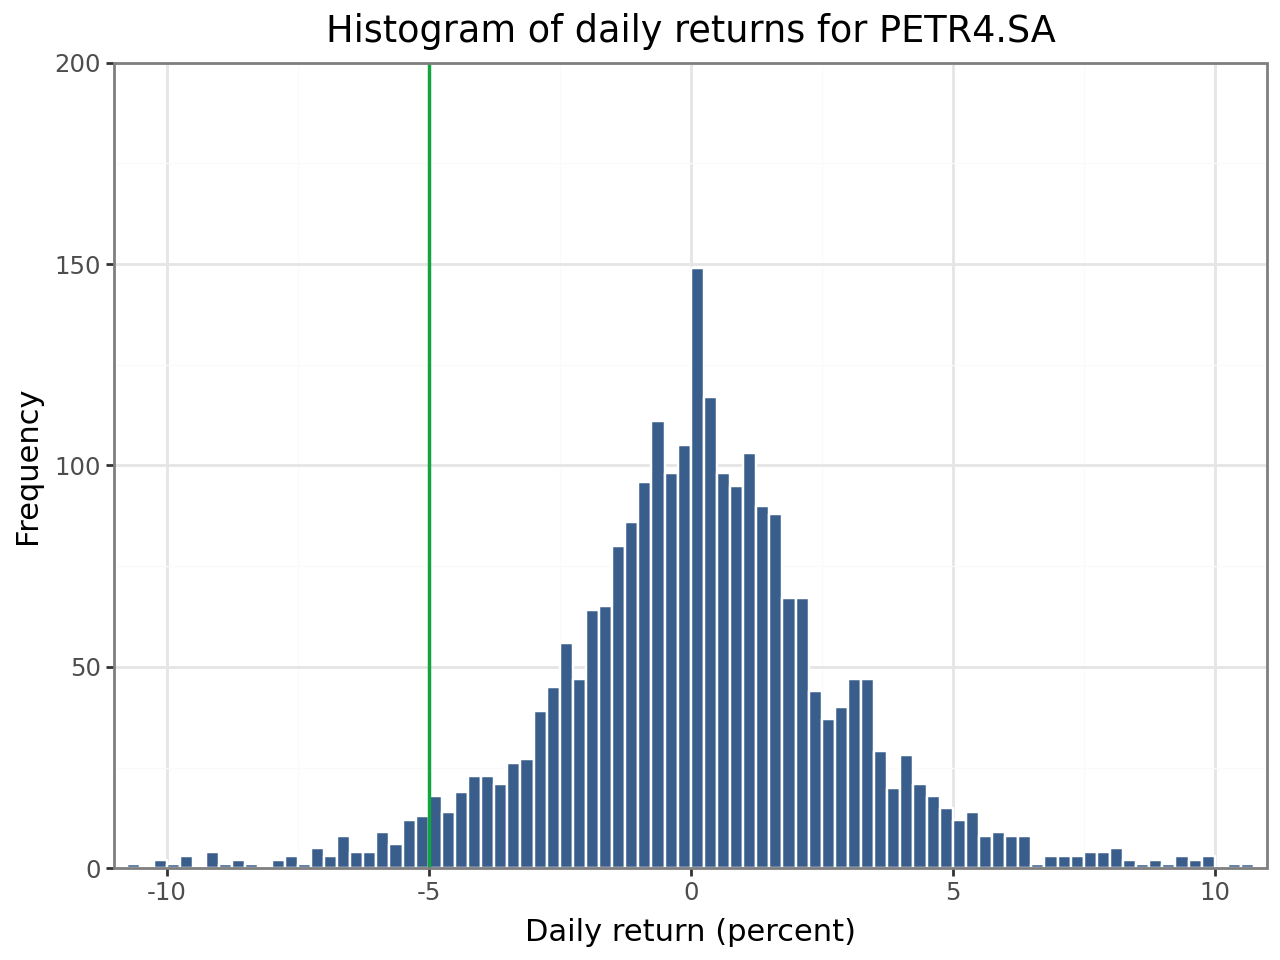

In [18]:
# Create histogram of daily returns
ggplot(petr4_df, aes("pct_return")) + geom_histogram(
    binwidth=0.25, color="white", fill=color[0], boundary=0, closed="left",
) + geom_vline(xintercept=-5, size=0.7, color=color[1]) + labs(
    x="Daily return (percent)", y="Frequency", title="Histogram of daily returns for PETR4.SA"
) + coord_cartesian(
    xlim=[-10, 10], ylim=[0, 200]
) + scale_y_continuous(
    expand=[0, 0]
) + geom_segment(
    aes(x=-6, y=220, xend=-5, yend=220)
) + annotate(
    "text", x=-8, y=220, label="5% loss", size=12
) + theme_bw()

We can notice a significant amount of observations below the 5% threshold. We can count the number of days that `PETR4.SA` closed at such low losses.

In [19]:
days_below_5pct = len(petr4_df.loc[petr4_df["pct_return"] <= -5, :])

days_below_5pct_proport = (days_below_5pct / petr4_df.shape[0]) * 100
print(f"There were {days_below_5pct} days in which the stock lost 5% or more. \nThis represents {days_below_5pct_proport:.2f}% of the total days ({petr4_df.shape[0]}).")

There were 97 days in which the stock lost 5% or more. 
This represents 3.90% of the total days (2490).


Now, for a total of 2490 days, we have noticed **97** days with losses below 5%, representing nearly **4%** of the total number of observations. 

## 3. Repeated samples, standar error ##
Considering the question "What *could* have been observed?", we can use **repeated samples** to make inferences about our dataset. That is, we can learn the distribution of each sample, get its estimate and observe the sampling distribution. Our most important goal here is to get its standard deviation, that is, how much *spread* we can observe across repeated samples. Remember that the standard deviation of the sampling distribution is called the **standard error**. 
We can now peform a simulation to exemplify the exercise. Our statistic of interest is the proportin of days with 5% of larger losses - in our case, it is **3.9%**. If we consider these 10 years of data our entire population, we already know the true value. We will ignore this fact and consider that the entire population encompasses a wider timespan.

In [20]:
# Remove NaN values from `pct_return` column
pct_return_no_na = petr4_df["pct_return"].dropna()

Using a simple random sampling, we can now create samples based on the assumption that our data comprises only a 4 year period. Considering that each year has around 250 working days, we can use `1000` as our sample size.

In [21]:
def create_samples(vector, n_samples, n_obs):
    samples_pctloss = [None] * (n_samples + 1) # Create a list to store the samples
    for i in range(n_samples + 1):
        single_sample = np.random.choice(vector, size=n_obs, replace=False) # Create a single sample
        samples_pctloss[i] = sum(single_sample <= -5) / n_obs * 100 # Calculate the proportion of days with losses greater than 5%
    return samples_pctloss


Now, we can generate samples for 1000 and 500 observations. It is important to mention that, in our case, we are ignoring any dependence from a given value to the previous observations. That is, we are destroying the time-series component of our dataset for the purpose of understanding the process of generalizing from data.

In [22]:
np.random.seed = 123
n_obs_1000 = create_samples(pct_return_no_na, 10000, 1000)
n_obs_500 = create_samples(pct_return_no_na, 10000, 500)

In [23]:
n_obs_df = pd.DataFrame({"n_obs_500": n_obs_500, "n_obs_1000": n_obs_1000}).drop(0)

In [24]:
n_obs_df

,n_obs_500,n_obs_1000
1,4.2,3.7
2,2.4,4.6
3,3.2,4.4
4,3.4,3.8
5,3.6,4.4
...,...,...
9996,3.4,4.4
9997,5.0,3.9
9998,3.0,4.0
9999,4.8,4.1


The result is a DataFrame containing the percentage points of `pct_return` at a 5%+ loss. 
We can now calculate the margin of error and use it to find the confidence interval for the mean of our dataset with 1000 observations. A few comments:
1. Margin of Error Calculation
- `norm.ppf(0.975)` calculates the **z-score** (or the number of standard deviations from the mean) corresponding to the 97.5th percentile of the standard normal distribution. We use `0.975` for a 95% CI as the normal distribution is symmetric, and we want the area in the middle covering 95% of the distribution. As such, 2.5% is left on each side.
- `np.std(n_obs["n_obs_1000"]) calculates the **standard deviation** of the dataset.
- `/ np.sqrt(len(n_obs_df["n_obs_1000"]))` divides the standard deviation by the **squared root of the number of observations** in the dataset. We can then calculate the **standard error** of the mean.
- The entire expression calculates the margin of error for the 95% CI of the mean.

2. CI Calculation
- `np.mean(n_obs_df["n_obs_1000"])`: This calculates the mean of the dataset.
- `left = np.mean(n_obs_df["n_obs_1000"]) - error`: This subtracts the margin of error from the mean to find the lower bound of the 95% confidence interval.
- `right = np.mean(n_obs_df["n_obs_1000"]) + error`: This adds the margin of error to the mean to find the upper bound of the 95% confidence interval.

In [26]:
error = norm.ppf(0.975) * np.std(n_obs_df["n_obs_1000"]) / np.sqrt(len(n_obs_df["n_obs_1000"]))
left = np.mean(n_obs_df["n_obs_1000"]) - error
right = np.mean(n_obs_df["n_obs_1000"] + error)

In [ ]:
ggplot(n_obs_df, aes(n_obs_1000[1:])) + geom_histogram(
    binwidth=0.1, color="white", fill=color[0], boundary=0, closed="left",
) + labs(x="Percent of days of losses of % or more", y="Frequency") + geom_vline(
    aes(xintercept=np.mean(pd.Series(n_obs_1000).dropna())), color
)